In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [3]:
from transformers import AutoTokenizer, BertModel
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
df = pd.read_csv ('/content/drive/MyDrive/ADRXAI/FinalADR.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df=df.dropna()
df.head()

,text,searchTerm,disease,processed_text
0,Buy top levothyroxine online on our free compa...,Levothyroxine,Cancer,"['buy', 'top', 'free', 'comparison', 'site', '..."
1,@femmebostonian @Cherrell_Brown This has been ...,Levothyroxine,Cancer,"['super', 'help', 'switch', 'due', 'cost', 'ne..."
2,For a decade I was on Levothyroxine 137 mcg. I...,Levothyroxine,Cancer,"['decad', 'see', 'even', 'bit', 'bad', 'heart'..."
3,@yourAAH Hi could you tell me which of your UK...,Levothyroxine,Cancer,"['hi', 'could', 'tell', 'stock']"
4,And my levothyroxine,Levothyroxine,Cancer,[]


In [5]:
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
import nltk
import re
import string
import pandas as pd
import numpy as np
from wordcloud import WordCloud
string.punctuation

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt_tab')


# Initialize stop words, English words corpus, and stemmer
stop_words = set(stopwords.words('english'))
english_words = set(words.words())
# stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
import nltk
nltk.download('punkt')
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the text column
df['Cleantext'] = df['text'].apply(preprocess)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
X=df.Cleantext
Y=df.disease
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.33, random_state=42)

# Further split temp into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
print(f'(X_train: {len(X_train)}\nx_val: {len(X_val)}\nx_test: {len(X_test)})')

(X_train: 2637
x_val: 650
x_test: 650)


In [ ]:
!pip install datasets

In [9]:
from datasets import Dataset

# Assuming X_test and y_test are pandas DataFrames or lists
data_dict = {
    'text': X_test.tolist(),  # Cleaned text (X_test)
    'label': y_test.tolist()  # Disease labels (y_test)
}

# Create a Hugging Face dataset
test_data = Dataset.from_dict(data_dict)

In [10]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

# Optionally, add the encoded labels back to your DataFrames
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [11]:
X_test_shap=X_test

In [12]:
X_train = X_train.tolist()
y_train = y_train.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()
y_val=y_val.tolist()
X_val=X_val.tolist()


In [13]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=649)
valid_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=649)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=649)


In [14]:
# Dataloader class
class DATALOADER(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = DATALOADER(train_encodings, y_train)
valid_dataset = DATALOADER(valid_encodings, y_val)
test_dataset = DATALOADER(test_encodings, y_test)

In [ ]:
!pip install peft

In [16]:
from transformers import AutoModelForSequenceClassification,AutoConfig

id2label = {0: 'Cancer', 1: 'Diabetes', 2: 'High_Bp'}
label2id = {label: idx for idx, label in id2label.items()}

# Load and update the configuration
config = AutoConfig.from_pretrained("roberta-base")
config.id2label = id2label
config.label2id = label2id
config.num_labels = 3  # Set the number of labels in the config

# Load the model using the updated config
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", config=config)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from peft import get_peft_model, LoraConfig, TaskType


def apply_best_lora(model):
    config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=8,
        lora_alpha=32,
        lora_dropout=0.2,
        target_modules=["self.query", "self.key", "self.value"],)
    lora_model = get_peft_model(model, config)
    return lora_model

In [19]:
lora_model = apply_best_lora(model)

In [20]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [21]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='./robertaresults',
    num_train_epochs=10,                # Number of training epochs
    per_device_train_batch_size=8,    # Training batch size
    per_device_eval_batch_size=20,
    gradient_accumulation_steps=2,# Evaluation batch size
    warmup_steps=500,                 # Number of warmup steps
    weight_decay=0.01,                # Weight decay
    logging_dir='./logs',             # Directory for logging
    load_best_model_at_end=True,      # Load the best model at the end
    evaluation_strategy="steps",      # Evaluate during training
    logging_steps=400,                # Number of steps between logging
    save_steps=400,                   # Number of steps between saves
    learning_rate=0.001,              # Learning rate
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
from transformers import  Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [23]:
import os
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_API_KEY"] = ""  # Clear any stored API key


In [24]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy
400,0.734800,0.149014,0.970769
800,0.228800,0.100152,0.978462
1200,0.134900,0.123546,0.973846
1600,0.072900,0.085720,0.980000


TrainOutput(global_step=1650, training_loss=0.2868434322241581, metrics={'train_runtime': 447.8972, 'train_samples_per_second': 58.875, 'train_steps_per_second': 3.684, 'total_flos': 1193219680773240.0, 'train_loss': 0.2868434322241581, 'epoch': 10.0})

In [25]:
trainer.evaluate()

{'eval_loss': 0.08572043478488922,
 'eval_accuracy': 0.98,
 'eval_runtime': 3.8827,
 'eval_samples_per_second': 167.41,
 'eval_steps_per_second': 8.499,
 'epoch': 10.0}

In [26]:
eval_results =trainer.evaluate(test_dataset)

# Predict on the evaluation dataset to get logits
predictions = trainer.predict(test_dataset)

In [27]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.0633377805352211,
 'eval_accuracy': 0.9861538461538462,
 'eval_runtime': 3.629,
 'eval_samples_per_second': 179.111,
 'eval_steps_per_second': 9.093,
 'epoch': 10.0}

In [28]:
import numpy as np

# Extract true labels
true_labels = predictions.label_ids

# Extract predicted labels (argmax over logits)
preds = np.argmax(predictions.predictions, axis=1)


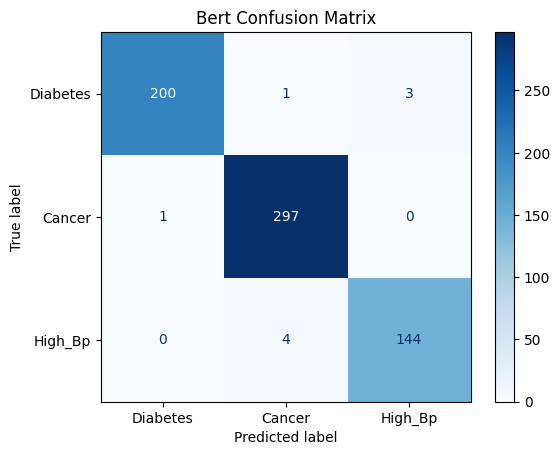

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = ['Diabetes', 'Cancer', 'High_Bp']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.title('Bert Confusion Matrix')
plt.show()


In [30]:
from sklearn.metrics import classification_report

# Assuming true_labels and preds are already defined
print(classification_report(true_labels, preds, target_names=labels))


              precision    recall  f1-score   support

    Diabetes       1.00      0.98      0.99       204
      Cancer       0.98      1.00      0.99       298
     High_Bp       0.98      0.97      0.98       148

    accuracy                           0.99       650
   macro avg       0.99      0.98      0.98       650
weighted avg       0.99      0.99      0.99       650



In [31]:
# saving the fine tuned model & tokenizer
model_path = "/content/drive/MyDrive/ADRXAI/loraroberta-base-shap"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/ADRXAI/loraroberta-base-shap/tokenizer_config.json',
 '/content/drive/MyDrive/ADRXAI/loraroberta-base-shap/special_tokens_map.json',
 '/content/drive/MyDrive/ADRXAI/loraroberta-base-shap/vocab.json',
 '/content/drive/MyDrive/ADRXAI/loraroberta-base-shap/merges.txt',
 '/content/drive/MyDrive/ADRXAI/loraroberta-base-shap/added_tokens.json',
 '/content/drive/MyDrive/ADRXAI/loraroberta-base-shap/tokenizer.json')

# ROC

In [32]:
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
true_labels = predictions.label_ids


In [33]:
import torch
import torch.nn.functional as F

# Convert logits to probabilities
probabilities = F.softmax(torch.tensor(logits), dim=-2).numpy()


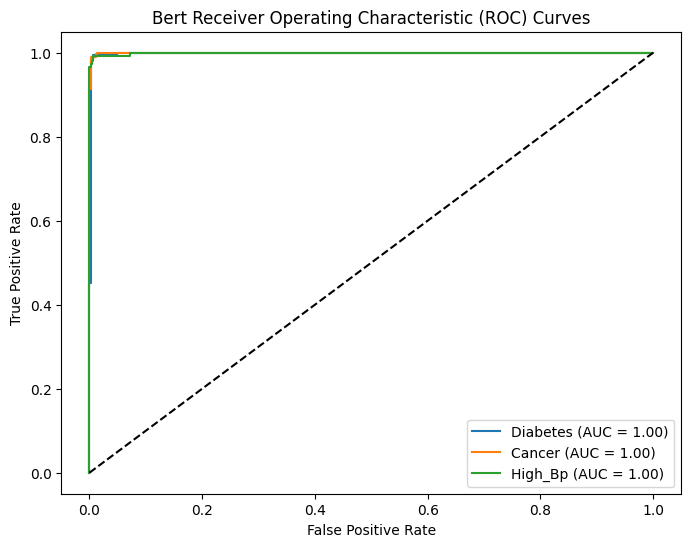

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming these are your class names
class_names = ['Diabetes', 'Cancer', 'High_Bp']  # Replace with your actual class names

num_classes = 3
true_labels_binarized = label_binarize(true_labels, classes=list(range(num_classes)))

# Compute ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bert Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


In [35]:
for i in range(num_classes):
    print(f'Class {i} AUC: {roc_auc[i]:.2f}')

Class 0 AUC: 1.00
Class 1 AUC: 1.00
Class 2 AUC: 1.00


In [36]:
import shap
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Define the path to your fine-tuned model and tokenizer
model_path = "/content/drive/MyDrive/ADRXAI/loraroberta-base-shap"

# Load the fine-tuned model and tokenizer from the saved path
tokenizer = AutoTokenizer.from_pretrained(model_path)
model1 = AutoModelForSequenceClassification.from_pretrained(model_path)

pred = transformers.pipeline(
    "text-classification",
    model=model1,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)

Some weights of the model checkpoint at /content/drive/MyDrive/ADRXAI/loraroberta-base-shap were not used when initializing RobertaForSequenceClassification: ['classifier.modules_to_save.default.dense.bias', 'classifier.modules_to_save.default.dense.weight', 'classifier.modules_to_save.default.out_proj.bias', 'classifier.modules_to_save.default.out_proj.weight', 'classifier.original_module.dense.bias', 'classifier.original_module.dense.weight', 'classifier.original_module.out_proj.bias', 'classifier.original_module.out_proj.weight', 'roberta.encoder.layer.0.attention.self.key.base_layer.bias', 'roberta.encoder.layer.0.attention.self.key.base_layer.weight', 'roberta.encoder.layer.0.attention.self.key.lora_A.default.weight', 'roberta.encoder.layer.0.attention.self.key.lora_B.default.weight', 'roberta.encoder.layer.0.attention.self.query.base_layer.bias', 'roberta.encoder.layer.0.attention.self.query.base_layer.weight', 'roberta.encoder.layer.0.attention.self.query.lora_A.default.weight',

In [37]:
masker = shap.maskers.Text(tokenizer=r"\W+") # this will create a basic whitespace tokenizer
explainer= shap.Explainer(pred, masker)

In [38]:
data = pd.DataFrame({"text": test_data["text"], "disease": test_data["label"]})

In [39]:
data[:3]

,text,disease
0,regulatory news us food drug administration dr...,Cancer
1,carvedilol district court case may needed prov...,High_Bp
2,rt pharmafactz antidiabetics rapidacting lispr...,Diabetes


In [40]:
shap_values = explainer(data["text"][:3])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:16,  5.45s/it]


In [41]:
shap.plots.text(shap_values)